In [1]:
library(limma)
library(edgeR)
options(repr.plot.width=12, repr.plot.height=8)

# 1. Data Pre-processing

* Data來源:
    * Tumor samples: [ICGC-GBM-US](https://dcc.icgc.org/releases/current/Projects/GBM-US)
    * Normal samples: [GTEx v7](https://gtexportal.org/home/datasetsO) only keep Brain-Cortex samples.
    * 只取兩邊都有測量到的gene然後合併起來。
* limma提供了計算Differential Expression(DE)的功能，但是我們也要提供他們所需的資料，以及格式。
* 因此我們需要參考操作手冊[limma](https://bioconductor.org/packages/release/bioc/vignettes/limma/inst/doc/usersguide.pdf)，本次課程只使用此package部分的功能，如果想了解更多請麻煩參考手冊。

In [2]:
df <- read.csv("GTEx_vs_TCGA_raw_counts.csv", row.names=1)

In [3]:
# 取出五個column，用 head 看前五個 row
head(df, n=5)

,WASH7P,OR4F5,OR4F29,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,⋯,BPY2,DAZ1,DAZ2,CDY1B,TTTY17B,DAZ3,DAZ4,TTTY4C,CDY1,types
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
GTEX-1117F-3226-SM-5N9CT,1042,3,1,7,58,2853,881,180,54,945,⋯,0,0,0,0,0,0,0,0,0,BrainCortex
GTEX-111FC-3126-SM-5GZZ2,745,1,2,15,53,3796,1114,23,13,374,⋯,0,0,0,0,0,0,0,0,0,BrainCortex
GTEX-1128S-2726-SM-5H12C,527,1,1,13,107,3547,1159,7,16,413,⋯,0,0,0,0,0,0,0,0,0,BrainCortex
GTEX-117XS-3026-SM-5N9CA,807,1,0,17,128,5594,1614,6,17,1644,⋯,0,0,0,0,0,0,0,0,0,BrainCortex
GTEX-1192X-3126-SM-5N9BY,808,1,1,9,118,3411,1420,6,14,769,⋯,0,0,0,0,0,0,0,0,0,BrainCortex


In [4]:
# 首先先將sample type取出，並轉成factor
sampleTypes <- factor(df$types, levels = c("GBM", "BrainCortex"))

# 拿掉types column
counts <- df[, -dim(df)[[2]]]
head(counts[,1:5])

,WASH7P,OR4F5,OR4F29,FAM41C,SAMD11
,<int>,<int>,<int>,<int>,<int>
GTEX-1117F-3226-SM-5N9CT,1042,3,1,7,58
GTEX-111FC-3126-SM-5GZZ2,745,1,2,15,53
GTEX-1128S-2726-SM-5H12C,527,1,1,13,107
GTEX-117XS-3026-SM-5N9CA,807,1,0,17,128
GTEX-1192X-3126-SM-5N9BY,808,1,1,9,118
GTEX-11DXW-1126-SM-5H12Q,544,3,2,9,56


In [5]:
n_samples <- nrow(counts)
n_genes <- ncol(counts)

cat(n_samples, n_genes)

324 18361

由於limma需要的格式為：
```row: gene, column: sample```

因此我們利用 ```t()```，做transpose，資料格式會變為matrix

In [6]:
counts <- t(counts)
class(counts)

[1] "matrix"

In [7]:
head(counts[,1:5])

,GTEX-1117F-3226-SM-5N9CT,GTEX-111FC-3126-SM-5GZZ2,GTEX-1128S-2726-SM-5H12C,GTEX-117XS-3026-SM-5N9CA,GTEX-1192X-3126-SM-5N9BY
WASH7P,1042,745,527,807,808
OR4F5,3,1,1,1,1
OR4F29,1,2,1,0,1
FAM41C,7,15,13,17,9
SAMD11,58,53,107,128,118
NOC2L,2853,3796,3547,5594,3411


到這裡為止，我們已經將最重要的兩個資訊，分別為gene~sample的counts table以及sample type的資訊，整理出來。

---

### 1-2. 將counts table，轉成 package 要的資料形式

裡面有兩個東西：一個是原本的count，一個是各sample的類別資訊

In [8]:
dge <- DGEList(counts)

In [9]:
head(dge$counts)

,GTEX-1117F-3226-SM-5N9CT,GTEX-111FC-3126-SM-5GZZ2,GTEX-1128S-2726-SM-5H12C,GTEX-117XS-3026-SM-5N9CA,GTEX-1192X-3126-SM-5N9BY,GTEX-11DXW-1126-SM-5H12Q,GTEX-11DXY-3226-SM-5GIDE,GTEX-11EI6-3026-SM-5GZZO,GTEX-11EMC-3226-SM-5EGKW,GTEX-11GS4-3126-SM-5A5LH,⋯,TCGA-41-3915-01A-01R-1850-01,TCGA-41-4097-01A-01R-1850-01,TCGA-41-5651-01A-01R-1850-01,TCGA-76-4925-01A-01R-1850-01,TCGA-76-4926-01B-01R-1850-01,TCGA-76-4927-01A-01R-1850-01,TCGA-76-4928-01B-01R-1850-01,TCGA-76-4929-01A-01R-1850-01,TCGA-76-4931-01A-01R-1850-01,TCGA-76-4932-01A-01R-1850-01
WASH7P,1042,745,527,807,808,544,375,540,516,400,⋯,1863,1676,2340,4103,1865,867,1504,2288,5189,1819
OR4F5,3,1,1,1,1,3,1,2,3,1,⋯,0,0,0,0,0,0,0,0,0,0
OR4F29,1,2,1,0,1,2,1,4,5,1,⋯,0,5,4,3,2,2,0,1,1,0
FAM41C,7,15,13,17,9,9,8,8,10,8,⋯,12,6,10,37,31,31,26,21,54,26
SAMD11,58,53,107,128,118,56,38,139,106,91,⋯,27,8,92,9,3,57,10,77,139,27
NOC2L,2853,3796,3547,5594,3411,4120,3302,2579,2258,2560,⋯,1848,1342,3444,5570,1922,1863,3551,2815,3711,4690


In [10]:
head(dge$sample)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
GTEX-1117F-3226-SM-5N9CT,1,39078027,1
GTEX-111FC-3126-SM-5GZZ2,1,50526122,1
GTEX-1128S-2726-SM-5H12C,1,44909321,1
GTEX-117XS-3026-SM-5N9CA,1,56998933,1
GTEX-1192X-3126-SM-5N9BY,1,45519666,1
GTEX-11DXW-1126-SM-5H12Q,1,48175944,1


### 1-3. 去除低表現量的基因

沒有表現量的基因表示這個基因在這個實驗中沒有什麼作用，所以去除掉這些基因可以減少一些雜訊，可以幫助我們找到真的DEG。

因此，我們用```rowSums```算出每一個row (gene)有幾個 sample 沒有表現量 (```counts == 0```)，```table```可以統計各種類的數目。

In [11]:
table(rowSums(dge$counts==0) == n_samples)


FALSE  TRUE 
18269    92 

In [12]:
(92/(18269+92)) * 100

[1] 0.501062

可以看到有大約```0.5%```的基因沒有在任何樣本中表現。

通常package也會提供一些方便使用的function來去除這些基因。例如：```edgeR``` 的 ```filterByExpr```

In [13]:
keep.exprs <- filterByExpr(dge, group=sampleTypes)
class(keep.exprs)

[1] "logical"

In [14]:
# keep.expr可以用來選擇要留下的 row (gene)
dge <- dge[keep.exprs,]

In [15]:
dim(dge)

[1] 15109   324

In [16]:
((18269+92) - 15109) / (18269+92)

[1] 0.1771145

根據```edgeR``` 的 ```filterByExpr```，基因從20531減少到15862，大致減少了```18%```

----

# 2. Normalization

處理好格式後，就可以用package提供的normalization來去除其他因素(包括：sequencing depth, gene length, etc.)。

```calcNormFactors()```函式可以吃進一個```DGEList```，輸出的東西一樣是```DGEList```，
唯一的變化是```norm.factors```會更新。

In [17]:
class(dge)

[1] "DGEList"
attr(,"package")
[1] "edgeR"

In [18]:
normed_dge <- calcNormFactors(dge, method =c("TMM")) # 這裡使用 TMM來normalize
head(normed_dge$sample, n=5)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
GTEX-1117F-3226-SM-5N9CT,1,39078027,1.0232886
GTEX-111FC-3126-SM-5GZZ2,1,50526122,1.0248801
GTEX-1128S-2726-SM-5H12C,1,44909321,1.0226138
GTEX-117XS-3026-SM-5N9CA,1,56998933,0.9752979
GTEX-1192X-3126-SM-5N9BY,1,45519666,1.0396858


CPM(Counts per million) 也是一種normalization，用來減少sequencing depth，但只能用來比較同一樣本中的重複樣本。

* 通常用來視覺化各種樣本的表現量分佈

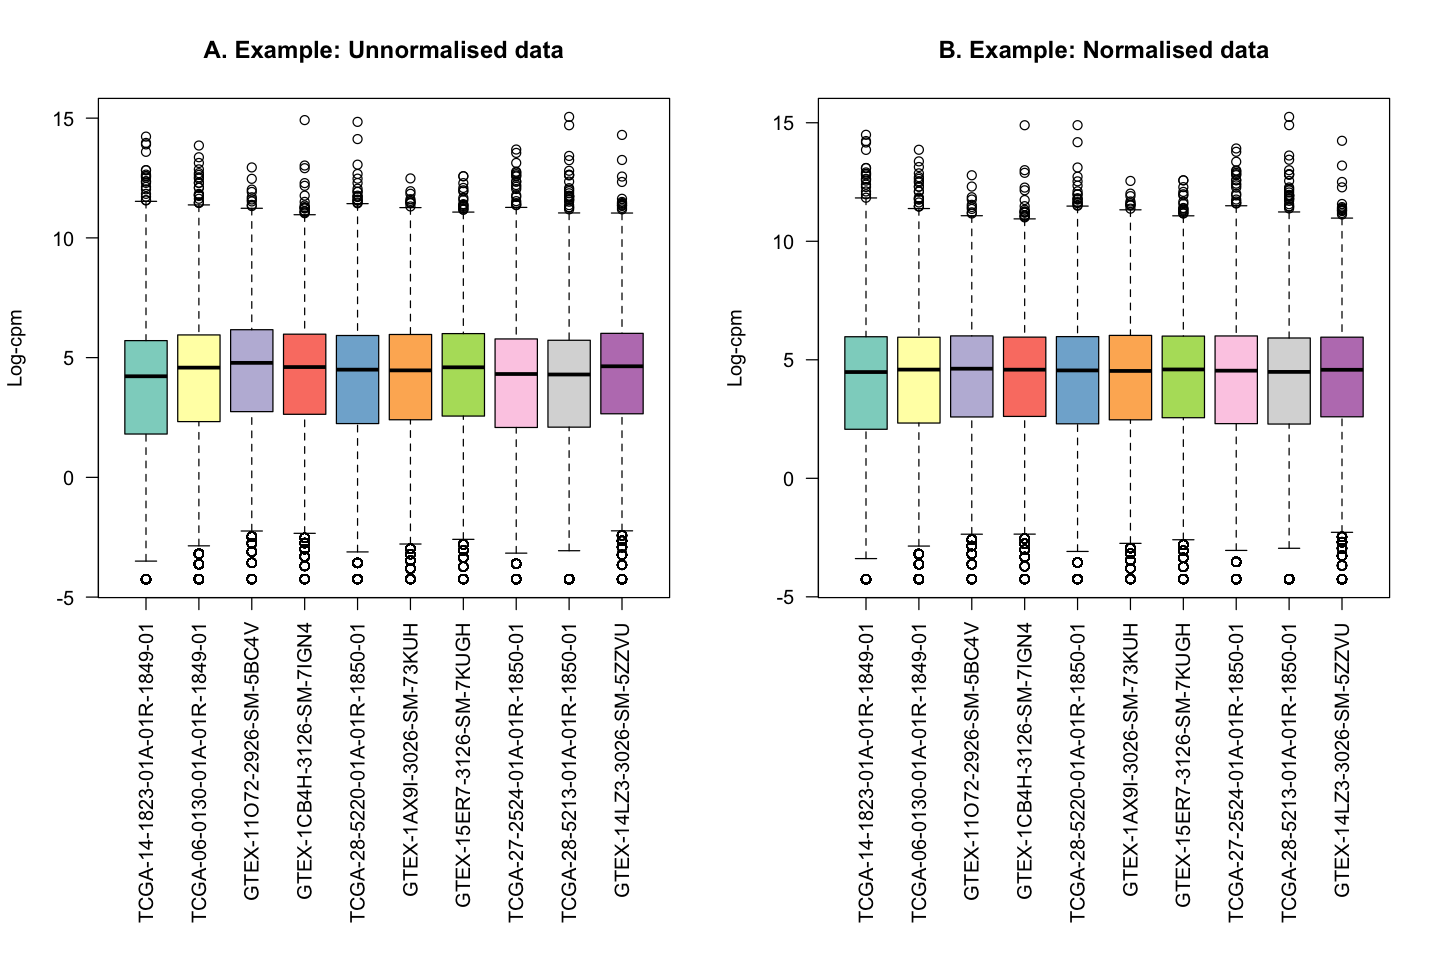

In [19]:
# 畫圖設定
library(RColorBrewer)
col <- brewer.pal(10, "Set3")
mar.default <- c(5,4,4,2) + 0.1
par(mfrow=c(1,2), mar=mar.default + c(10, 0, 0, 0), bg = 'white')

# 隨機取10個sample
s = sample.int(n=n_samples, size=10)

unnormalized <- cpm(dge, log=TRUE)[, s]
boxplot(unnormalized, las=2, col=col, main="")
title(main="A. Example: Unnormalised data",ylab="Log-cpm")

normalized <- cpm(normed_dge, log=TRUE)[, s]
boxplot(normalized, las=2, col=col, main="")
title(main="B. Example: Normalised data",ylab="Log-cpm")

# 3. Differential Expression Analysis

### 3-1. Fit linear models in limma

Limma fits a linear model to each gene:

Linear model 通常長這樣：
$$
Y = \beta_0 + \beta_{1}X_{1} + \beta_{2}X_{2} + \dots + \beta_{p}X_{p} + \epsilon
$$

* $Y$是基因的表現量
* $X_{n}$是共變量(covariate)，例如：這個樣本的屬於Tumor / Normal、樣本是從男或是女病人身上取得等等，也就是所謂的[Design Matrix](https://en.wikipedia.org/wiki/Design_matrix)。
    * ```model.matrix```是個將factor轉換成design matrix的方法。
* $\beta$是這個model要預估的參數，在limma中，就是log fold changes。
* $\epsilon$是誤差，通常假設是常態分佈。

### 3-1-1. Design Matrix

In [20]:
design <- model.matrix( ~ 0 + sampleTypes)
colnames(design) <- c("GBM", "BrainCortex")
head(design)

,GBM,BrainCortex
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1


### 3-1-2. Contrast Matrix

在這裡的用處是：定義要看哪幾組的差異，像是我們要看的差異是 GBM - BrainCortex。

由於在limma裡面，表現量是以$log_{2}$CPM表示，因此兩組的表現量相減其實就是**$log_2$ fold change**

In [21]:
contr.matrix <- makeContrasts(
   TumorVsNormal = GBM - BrainCortex, 
   levels = colnames(design)
)

contr.matrix

,TumorVsNormal
GBM,1
BrainCortex,-1


### 3-1-3. Removing heteroscedascity from count data

* [heteroscedascity](https://en.wikipedia.org/wiki/Heteroscedasticity) (異方差性)：
    * 方差指的就是Variance，異方差性就是指各樣本的Variance不相同。這個現象經常出現在RNA-seq的資料中。而且若有這個現象會讓linear model的假設不成立，導致找到的DEG並不是真的DEG。


* 因此有人提出```voom```這個方式來轉換RNA-seq的資料，讓轉換後的資料也可以用linear model和其他microarray的分析方法。


* What is voom doing?

    * 首先counts會被轉換成log2 counts per million reads (CPM)。("per million reads" 是根據[```norm.factors```](#2.-Normalization)的數值而定，因此有沒有先normalize會有差別)
    * 對每個基因的log2 CPM fit一個線性模型，並計算出殘差($\epsilon$)。
        * log2 CPM 基因表現量 $ = \beta_0 + \beta_{1}X_{1} + \beta_{2}X_{2} + \dots + \beta_{p}X_{p} + \epsilon$
    * (圖中紅線)，Fit a LOWESS curve，用平均log2 CPM來預測殘差分佈的變化量。(變化量愈大，表示這個基因的線性模型的殘差變化愈大)
        * log2 CPM 基因表現量 $ = \sqrt(residual\_standard\_deviation)$
        * LOWESS (locally weighted scatterplot smoothing): 跟fit線性模型差不多，差別在於每次fit時只看部分區域的資料，每個資料點在fit線性模型時有不同的weight。[詳細解說看這裡](https://www.youtube.com/watch?v=Vf7oJ6z2LCc)
    * 得到LOWESS curve之後，每個基因在每個樣本中都會有得到一個 weight數值，讓limma可以根據這個數值讓表現量更符合linear model的假設.

More details at https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-2-r29

In [22]:
class(normed_dge)

[1] "DGEList"
attr(,"package")
[1] "edgeR"

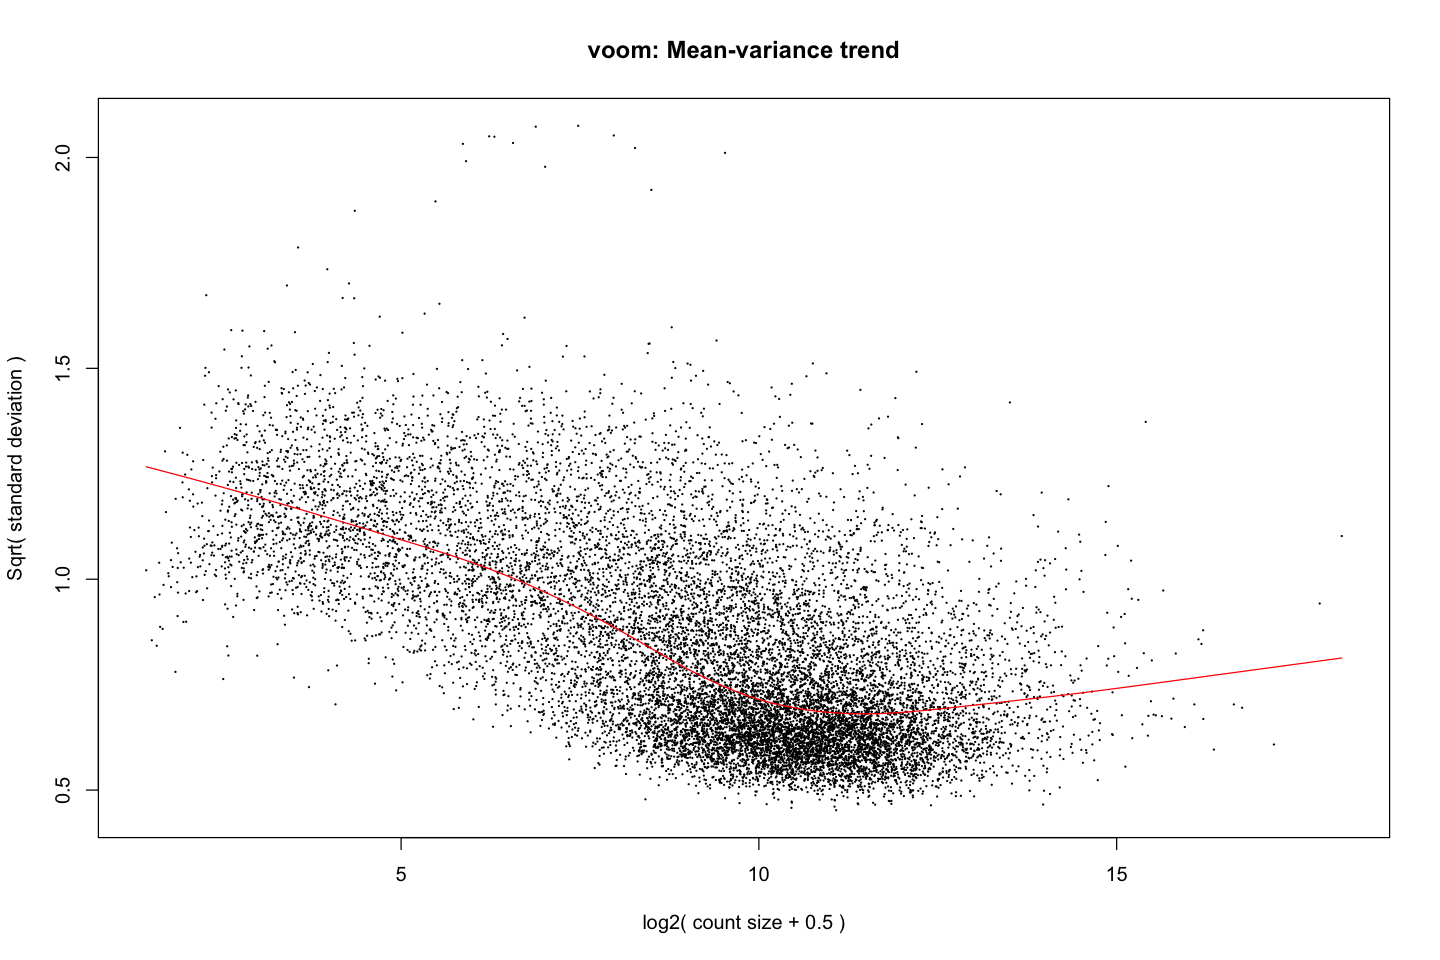

In [23]:
mar.default <- c(5,4,4,2) + 0.1
par(mfrow=c(1,1), mar=mar.default, bg = 'white')

y <- voom(normed_dge, design, plot = T)

In [24]:
print(names(y))
cat(class(y))

[1] "targets" "E"       "weights" "design" 
EList

現在```y```這個變數裡面有所有```limma```需要的資訊。

### 3-1-4. Fit the linear models

In [25]:
fit <- lmFit(y, design)
head(coef(fit))

,GBM,BrainCortex
WASH7P,6.03750631,3.5888875
FAM41C,-0.87166922,-2.4214746
SAMD11,0.05566178,0.6753900
NOC2L,6.30936879,6.1714471
KLHL17,2.85020854,4.3349288
C1orf170,-2.37757183,-0.8796414


In [26]:
cfit <- contrasts.fit(fit, contr.matrix)

Empirical Bayes smoothing of standard errors (for detail: [here](https://www.degruyter.com/doi/10.2202/1544-6115.1027))

這是原本用在microarray上的一個方法，它可以讓各個基因的模型殘差趨近於一個共同數值。

在檢定基因是否有顯著表現差異時，會得到比較符合證據的結果。

In [27]:
efit <- eBayes(cfit, robust=TRUE)
class(efit)

[1] "MArrayLM"
attr(,"package")
[1] "limma"

```topTable```可以輸出各個基因在我們定義下的差異中，表現量變化和相關的統計檢定結果。

* logFC: log2 fold change of Tumor/Normal
* AveExpr: Average expression across all samples, in log2 CPM
* t: logFC divided by its standard error
* P.Value: Raw p-value (based on t) from test that logFC differs from 0
* adj.P.Val: Benjamini-Hochberg false discovery rate adjusted p-value
* B: log-odds that gene is DE (arguably less useful than the other columns)

In [28]:
top.table <- topTable(efit, sort.by = "P", n = Inf)
head(top.table, 20)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GTF2IP1,9.739493,4.4213092,129.28364,2.638676e-282,3.986776e-278,634.3807
SNORA8,10.288601,-1.0987840,109.65634,1.678716e-259,1.268186e-255,581.0091
MRPL30,10.170752,0.5032906,106.99228,4.126609e-256,2.078298e-252,573.6667
AMIGO3,9.620257,-1.4693117,101.92633,1.945237e-249,7.347647e-246,558.2973
EIF3CL,9.586048,3.9179844,101.56710,5.942565e-249,1.795724e-245,558.9197
DEXI,7.336701,1.7687940,97.16624,7.074365e-243,1.781443e-239,544.7877
SPDYE8P,7.100599,-2.6679899,96.82521,2.143768e-242,4.627171e-239,541.6973
RABGEF1,4.517846,3.8580007,94.92297,1.112515e-239,2.101123e-236,538.6513
C14orf169,9.188391,-1.6796623,94.59597,3.297232e-239,5.535319e-236,535.2316


```decideTests```: 預設 adjusted p-value < 0.05 為 DEG

In [29]:
et <- decideTests(efit)
summary(et)

       TumorVsNormal
Down            7050
NotSig          1087
Up              6972

### 3-2. ```treat```: 使用更嚴苛的條件來決定 DEG

In [30]:
tfit <- treat(cfit, lfc=2, robust=TRUE)
dt <- decideTests(tfit)
summary(dt)

       TumorVsNormal
Down            2075
NotSig         11823
Up              1211

In [31]:
top.treat.table <- topTreat(tfit, sort.by = "P", n = Inf)
head(top.treat.table, 20)

,logFC,AveExpr,t,P.Value,adj.P.Val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GTF2IP1,9.739493,4.4213092,102.73531,7.972881e-251,1.204623e-246
SNORA8,10.288601,-1.0987840,88.34025,3.527648e-230,2.664961e-226
MRPL30,10.170752,0.5032906,85.95307,1.859354e-226,9.364324e-223
AMIGO3,9.620257,-1.4693117,80.73639,5.533752e-218,2.090236e-214
EIF3CL,9.586048,3.9179844,80.37649,2.217251e-217,6.700088e-214
DDX47,11.075623,0.7699845,77.30875,3.846407e-212,9.685893e-209
C14orf169,9.188391,-1.6796623,74.00564,2.747161e-206,5.929550e-203
RGPD6,9.622570,0.2134805,72.16645,6.306901e-203,1.191137e-199
ACAD11,10.975482,-0.2982368,70.83509,1.906538e-200,3.200654e-197


# 4. Data Visualization

### 4-1. Volcano Plot

* x軸：log2 fold change
* y軸：-log10 adjusted p-value

可以一次呈現所有DEGs。算是Differential Expression Analysis最常用來視覺化的圖。

In [32]:
library(ggplot2)
library(ggrepel)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



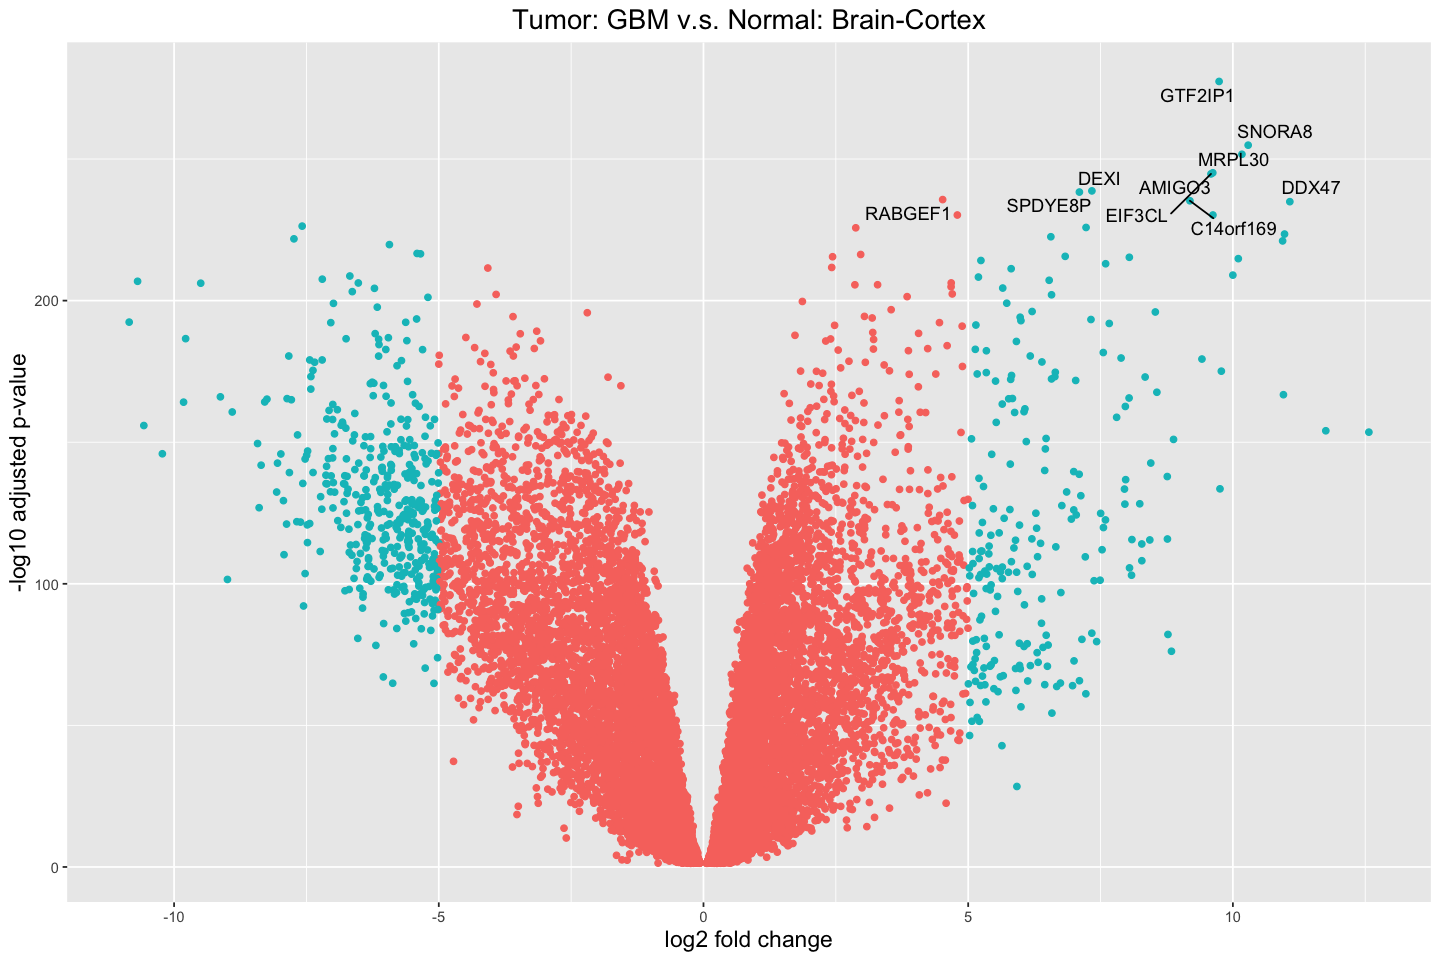

In [33]:
top.table$is_overexpr = (top.table$adj.P.Val < 1e-12) & (abs(top.table$logFC) >= 5)

real_DEGs_df <- top.table[top.table$adj.P.Val < 0.05,]
real_DEGs_df$genelabels = ""
real_DEGs_df$genelabels[1:10] <- rownames(real_DEGs_df)[1:10]

ggplot(real_DEGs_df, 
       aes(x = logFC, y = -log10(adj.P.Val))) +
        geom_point(aes(color = is_overexpr)) + 
        geom_text_repel(aes(label = genelabels)) +
        ggtitle("Tumor: GBM v.s. Normal: Brain-Cortex") +
        xlab("log2 fold change") + 
        ylab("-log10 adjusted p-value") +
        theme(legend.position = "none",
              plot.title = element_text(size = rel(1.5), hjust = 0.5),
              axis.title = element_text(size = rel(1.25)))  

### 4-2. Mean-Difference Plot

如名字所示，x軸為平均表現量、y軸是log2 fold change。

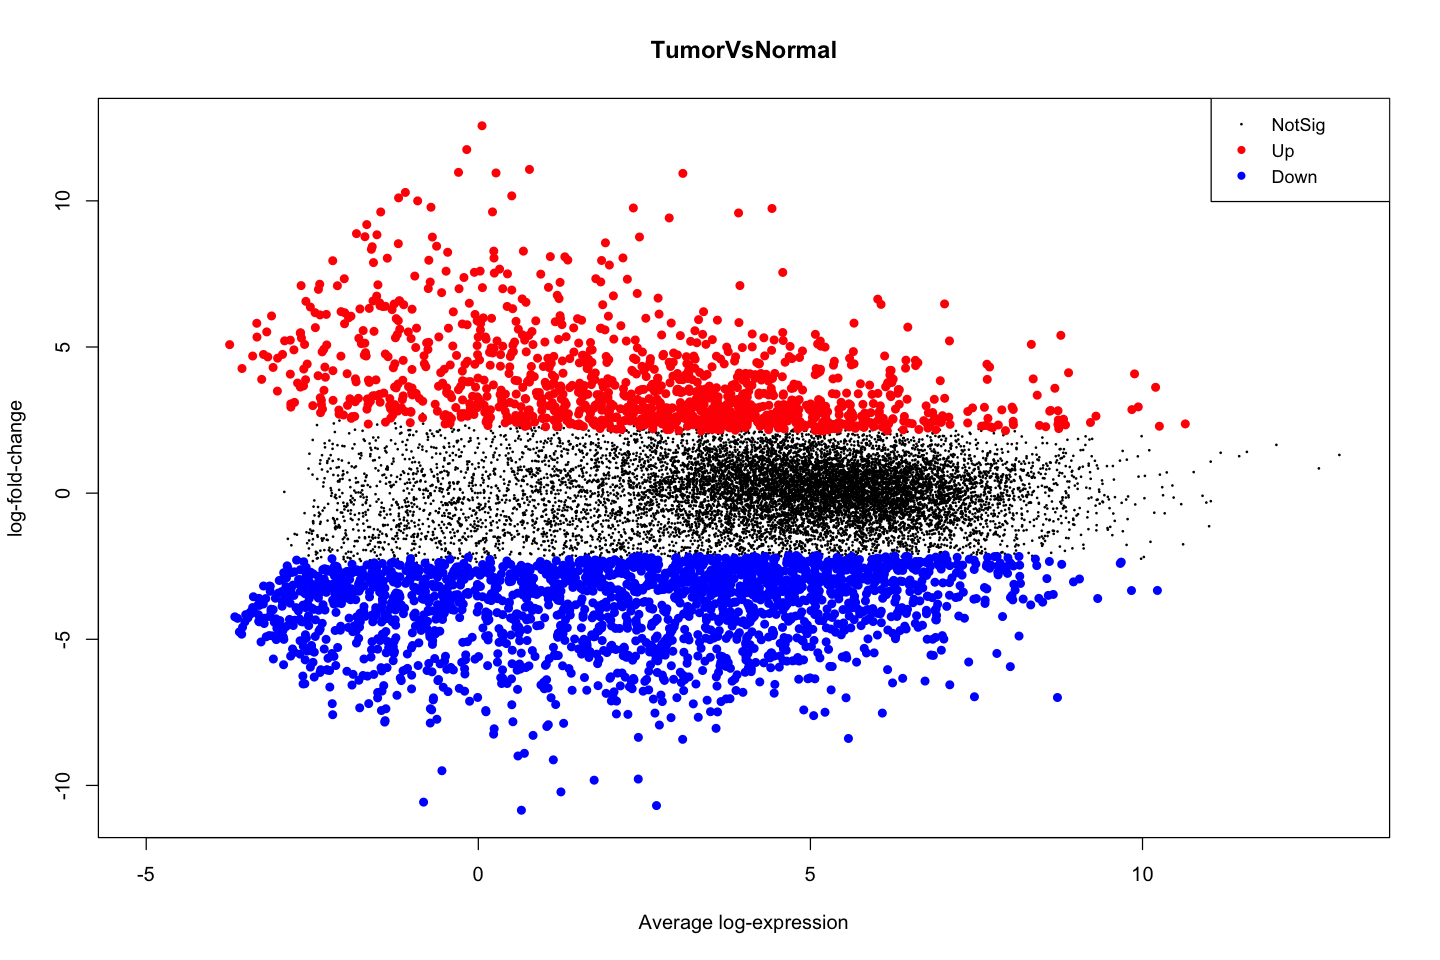

In [34]:
mar.default <- c(5,4,4,2) + 0.1
par(mfrow=c(1,1), mar=mar.default, bg = 'white')

plotMD(tfit, column=1, status=dt[,1], main=colnames(tfit)[1], 
       xlim=c(-5,13))

### 4-3. Plot single gene expression

可以用boxplot簡單呈現單一或多個基因在不同組的表現量。

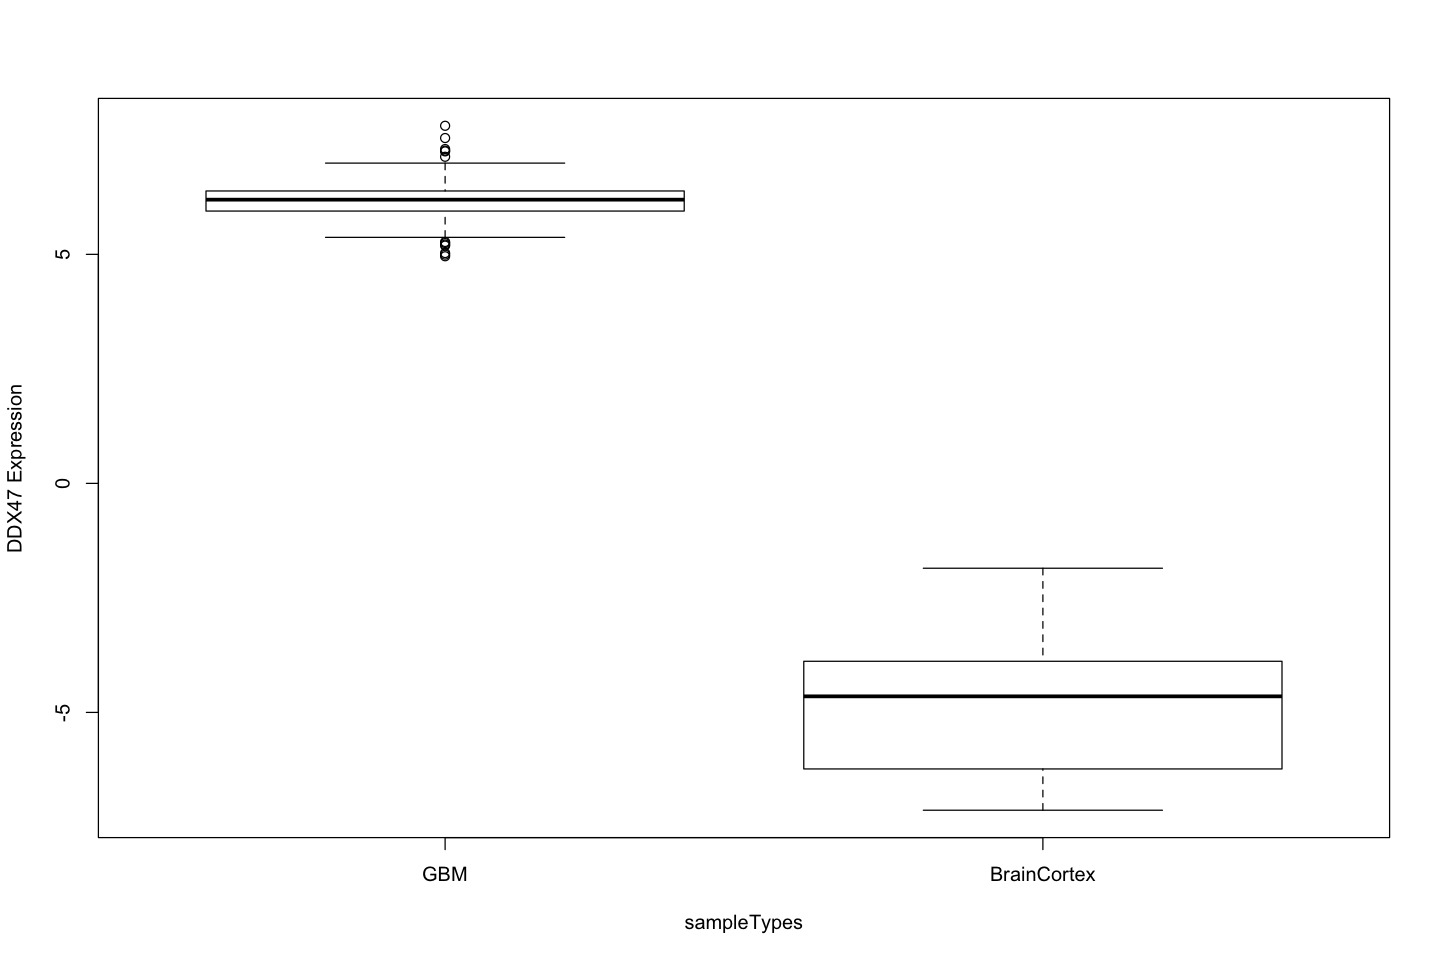

In [35]:
mar.default <- c(5,4,4,2) + 0.1
par(mfrow=c(1,1), mar=mar.default, bg = 'white')

boxplot(y$E["DDX47",] ~ sampleTypes,
        ylab="DDX47 Expression")

# 5. Save the Results

In [36]:
?write.csv

write.table {utils},R Documentation
x,"the object to be written, preferably a matrix or data frame. If not, it is attempted to coerce x to a data frame."
file,"either a character string naming a file or a connection open for writing. """" indicates output to the console."
append,"logical. Only relevant if file is a character string. If TRUE, the output is appended to the file. If FALSE, any existing file of the name is destroyed."
quote,"a logical value (TRUE or FALSE) or a numeric vector. If TRUE, any character or factor columns will be surrounded by double quotes. If a numeric vector, its elements are taken as the indices of columns to quote. In both cases, row and column names are quoted if they are written. If FALSE, nothing is quoted."
sep,the field separator string. Values within each row of x are separated by this string.
eol,"the character(s) to print at the end of each line (row). For example, eol = ""\r\n"" will produce Windows' line endings on a Unix-alike OS, and eol = ""\r"" will produce files as expected by Excel:mac 2004."
na,the string to use for missing values in the data.
dec,the string to use for decimal points in numeric or complex columns: must be a single character.
row.names,"either a logical value indicating whether the row names of x are to be written along with x, or a character vector of row names to be written."
col.names,"either a logical value indicating whether the column names of x are to be written along with x, or a character vector of column names to be written. See the section on ‘CSV files’ for the meaning of col.names = NA."


In [37]:
write.fit(tfit, dt, file="./results.txt")

# References
* https://www.bioconductor.org/packages/devel/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html#reading-in-count-data
* https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop/thursday/DE.html
* 107-2 NTU Bioinformatics RNA-Seq Differential Analysis by Wei-Hao, Lee @ 4/25/2019